In [1]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import os
import numpy as np
import random

import pandas as pd 
#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff 
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from patchify import patchify
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from glob import glob
import cv2
import random
seed =42
np.random.seed=42

In [4]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
SIZE_X = 256
SIZE_Y = 256
n_classes = 20

In [6]:
train_images = []

for directory_path in glob.glob("/Users/anshugusain/tf-nuclei/content/publicX/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

train_images = np.array(train_images)

In [7]:
train_masks = [] 
for directory_path in glob.glob("/Users/anshugusain/tf-nuclei/content/publicY/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [8]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


_label.py (116): A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [9]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [10]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)

y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19]


In [11]:
from sklearn.utils import class_weight
weight = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(train_masks_reshaped_encoded),y= train_masks_reshaped_encoded)
weight = {i : weight[i] for i in range(20)}


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [12]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
s = inputs

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

#NOTE: Compile the model in the main program to make it easy to test with various loss functions
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

#loss = 'focal_loss'

model.summary()

Metal device set to: Apple M2 Pro


2023-05-21 15:42:22.057397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-21 15:42:22.057887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
history = model.fit(X_train, y_train_cat, batch_size = 16, epochs=45, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=weight,
                    shuffle=False)

Epoch 1/45


2023-05-21 15:42:25.488150: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-21 15:42:25.973196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 2s 379ms/step - loss: 3.0003 - accuracy: 0.0893 - val_loss: 2.7220 - val_accuracy: 0.4898
Epoch 2/45


2023-05-21 15:42:27.281336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 137ms/step - loss: 2.5887 - accuracy: 0.4947 - val_loss: 2.7786 - val_accuracy: 0.7204
Epoch 3/45
3/3 [==============================] - 0s 132ms/step - loss: 2.5917 - accuracy: 0.6922 - val_loss: 2.4512 - val_accuracy: 0.7281
Epoch 4/45
3/3 [==============================] - 0s 131ms/step - loss: 1.9435 - accuracy: 0.7266 - val_loss: 1.5268 - val_accuracy: 0.7292
Epoch 5/45
3/3 [==============================] - 0s 132ms/step - loss: 1.4068 - accuracy: 0.7483 - val_loss: 1.5953 - val_accuracy: 0.7292
Epoch 6/45
3/3 [==============================] - 0s 132ms/step - loss: 1.2667 - accuracy: 0.7515 - val_loss: 1.2981 - val_accuracy: 0.7292
Epoch 7/45
3/3 [==============================] - 0s 131ms/step - loss: 1.1737 - accuracy: 0.7517 - val_loss: 1.1846 - val_accuracy: 0.7292
Epoch 8/45
3/3 [==============================] - 0s 131ms/step - loss: 1.1281 - accuracy: 0.7515 - val_loss: 1.3025 - val_accuracy: 0.7292
Epoch 9/45
3/3 [===============

In [14]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 70ms/step - loss: 0.9428 - accuracy: 0.7292
Accuracy is =  72.92455434799194 %


In [15]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 0s 268ms/step


2023-05-21 15:42:51.906010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


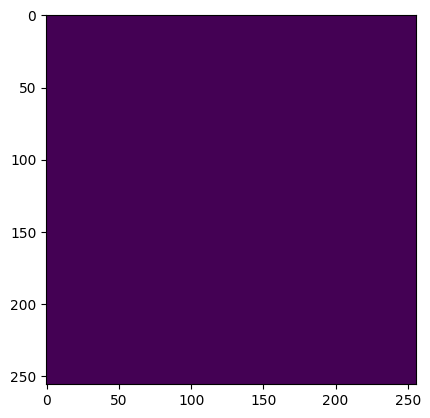

In [19]:
plt.imshow(y_pred_argmax[3]*255)

1/1 [==============================] - 0s 79ms/step - loss: 0.9428 - accuracy: 0.7292
Accuracy is =  72.92455434799194 %


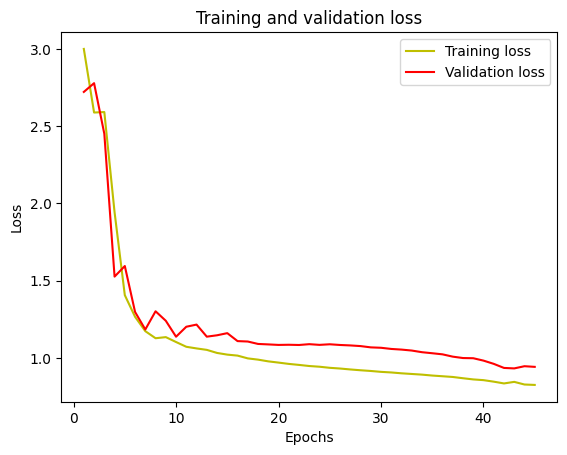

In [17]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyError: 'acc'